Bem-vindo(a) à apresentação!

Neste notebook, há um resumo de todas as técnicas que usei para atingir os objetivos e entregas propostos.

O texto, imagens e arquivos vão estar organizados na ordem de entrega propostas, seguindo o sumário à seguir, desde já, agradeço pela atenção.

Ass: Hugo da Costa Gomes

Sumário:

---
1.0. Análise Exploratória dos Dados  
---
 > 1.1. Análise inicial e Limpeza de Dados

 > 1.2. Merge com Segundo Banco de Dados

 > 1.3. Análise pós-limpeza

---
2.0. Perguntas baseadas nos dados
---

> 2.1. Qual filme você recomendaria para uma pessoa que você não
conhece? (A)

> 2.2. Quais são os principais fatores que estão relacionados com alta
expectativa de faturamento de um filme? (B)

> 2.3. Quais insights podem ser tirados com a coluna Overview? É possível
inferir o gênero do filme a partir dessa coluna? (C)

---
3.0. Execução de modelo para previsão de nota do IMDB
---

---
4.0. Previsão da nota: Regressão ou Classificação?
---

------
5.0. Conclusão e Considerações Finais
---
------

# 1.0. Análise Exploratória dos Dados





## 1.1. Análise inicial e Limpeza de Dados

In [5]:
#Fazendo importação de bibliotecas que vão ser usadas no projeto

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import pearsonr, spearmanr
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Carregando o Dataset como um arquivo .csv e observando estado inicial do dataset
df = pd.read_csv('https://raw.githubusercontent.com/Coolffee/LH_CD_HugoGomes/main/desafio_indicium_imdb.csv')
df.head()

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


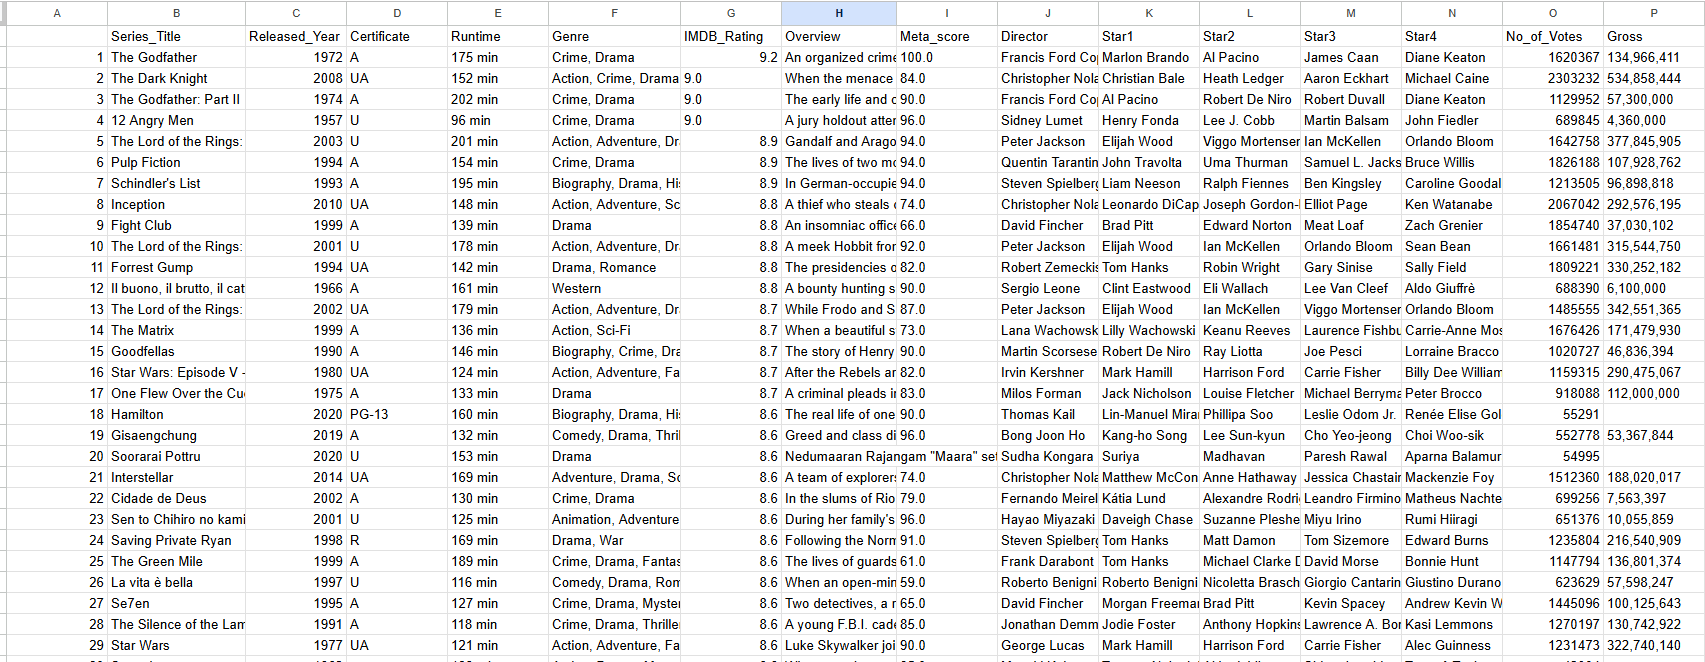

Daqui pode-se observar um resumo de como os dados estão estruturados, tendo uma visão básica do que pode ser importante e também de alguns erros na estrutura dos dados.

Tendo uma visão mais clara dos dados que vão ser utilizados, vamos analisar melhor:

In [7]:
print(df.info())
print("-------------------------------------------------------")
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB
None
---------------------------------

Podemos ver pela coluna "Dtype" que temos alguns erros, provavelmente gerados quandos os dados foram transportados para a database e alguns ajustes que podemos fazer:

Diversas colunas como em "Gross" estão em formatos de dados errados como object, quando na verdade deveriam ser do tipo float como dados quantitativos.
Runtime também apresenta o mesmo problema, mas por motivos diferentes, por ter escrito "min", depois dos números, ele detecta como strings.

Também temoss diversos valores nulos/vazios, que vão afetar na acurácia das análises.

Além disso, temos algumas informações interessantes com df.describe, mostrando valores mínimos, máximos, média e etc.

Os problemas vão ser resolvidos da seguinte maneira:

In [8]:
# Agora ignoramos as linhas em que tem dados vazios nas colunas.
df['Certificate'].fillna('Unknown', inplace=True)
# Tirar o " min" da coluna Runtime
df['Runtime'] = df['Runtime'].str.replace(' min', '', regex=False)
# Retirando vírgulas em Gross
df['Gross'] = df['Gross'].str.replace(',', '', regex=False)
#Adicionalmente, para facilitar no futuro, renomeando Unnamed para "Ranking"
df.rename(columns={'Unnamed: 0': 'Ranking'}, inplace=True)

trans_col = ['Released_Year', 'Runtime', 'Gross', 'No_of_Votes', 'IMDB_Rating', 'Meta_score']
for col in trans_col:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['Released_Year'] = df['Released_Year'].astype('Int64')
df['No_of_Votes'] = df['No_of_Votes'].astype('Int64')
df['Gross'] = df['Gross'].astype('Int64')
df['Meta_score'] = df['Meta_score'].astype('Int64')
df['Runtime'] = df['Runtime'].astype('float')
df['IMDB_Rating'] = df['IMDB_Rating'].astype('float')

print(df.info())
print("-------------------------------------------------------")
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ranking        999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  998 non-null    Int64  
 3   Certificate    999 non-null    object 
 4   Runtime        999 non-null    float64
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    Int64  
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    Int64  
 15  Gross          830 non-null    Int64  
dtypes: Int64(4), float64(2), int64(1), object(9)
memory usage: 128.9+ KB
None
------------------------

Agora estamos indo a algum lugar!

Temos também algumas outras coisas que podem ser separadas para que as análises sejam mais precisas.

Aqui separos gêneros em 3 colunas diferentes, uma para cada gênero e também criamos uma nova coluna a partir do Runtime, para termos controle de tempo de filme em certas categorias, fazendo uma nova coluna chamada RuntimeCateg.

In [9]:
# dividindo os generos que estão juntos em genre entre genre 1,2 e 3 para facilitar análises futuras.
df['Genre1'] = df['Genre'].str.split(',').str[0].str.strip().str.lower()
df['Genre2'] = df['Genre'].str.split(',').str[1].str.strip().str.lower()
df['Genre3'] = df['Genre'].str.split(',').str[2].str.strip().str.lower()
df.drop(columns=['Genre'], inplace=True)

# transformação do runtime em strings que classificam entre o mínimo e máximo (72 e 238)
bins = [72, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 238]
labels = ['72-80', '80-90', '90-100', '100-110', '110-120', '120-130', '130-140', '140-150', '150-160', '160-170', '170-180', '180-190', '190-200', '200-210', '210-220', '220-230', '230-238']
df['RuntimeCateg'] = pd.cut(df['Runtime'], bins=bins, labels=labels, right=False)

df.head()

,Ranking,Series_Title,Released_Year,Certificate,Runtime,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Genre1,Genre2,Genre3,RuntimeCateg
0,1,The Godfather,1972,A,175.0,9.2,An organized crime dynasty's aging patriarch t...,100,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411,crime,drama,NaN,170-180
1,2,The Dark Knight,2008,UA,152.0,9.0,When the menace known as the Joker wreaks havo...,84,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444,action,crime,drama,150-160
2,3,The Godfather: Part II,1974,A,202.0,9.0,The early life and career of Vito Corleone in ...,90,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000,crime,drama,NaN,200-210
3,4,12 Angry Men,1957,U,96.0,9.0,A jury holdout attempts to prevent a miscarria...,96,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000,crime,drama,NaN,90-100
4,5,The Lord of the Rings: The Return of the King,2003,U,201.0,8.9,Gandalf and Aragorn lead the World of Men agai...,94,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905,action,adventure,drama,200-210


Também temos o problema de que as classificações indicativas não são exatamentes padronizadas, decidi deixar da seguinte maneira:

Para Todos os Públicos: U, G

Supervisão dos Pais Sugerida: PG, PG-13, GP, TV-PG

Público Maduro (Adulto/Adolescente): A, UA, TV-14

Restrito a Adultos: R, TV-MA, 16

Outros/Desconhecidos: Unrated, Unknown, Passed, Approved

No caso, ficaria desse jeito:

Livre: U, G

PG: PG, PG-13, GP, TV-PG

A: A, UA, TV-14

R: R, TV-MA, 16

In [10]:
df["Certificate"] = df["Certificate"].replace({
    "U": "Livre",
    "G": "Livre",

    "PG": "PG",
    "PG-13": "PG",
    "GP": "PG",
    "TV-PG": "PG",

    "A": "A",
    "UA": "A",
    "TV-14": "A",

    "R": "R",
    "TV-MA": "R",
    "16": "R",

    "Unrated": "Others",
    "Unknown": "Others",
    "Passed": "Others",
    "Approved": "Others"
})

A partir daqui, o dataframe está limpo e pronto para ser usado em análises ou transformado em dataframes diferentes.

In [11]:
# Criar df_finops (subconjunto limpo para análises financeiras e de crítica, retirando dados nulos que são especialmente importante para tais.)
df_finops = df.dropna(subset=['Released_Year', 'Gross', 'No_of_Votes', 'IMDB_Rating', 'Meta_score']).copy()

df_finops['Gross'] = df_finops['Gross'].astype('int64')
df_finops['Meta_score'] = df_finops['Meta_score'].astype('int64')
df_finops['Released_Year'] = df_finops['Released_Year'].astype('int64')
df_finops['No_of_Votes'] = df_finops['No_of_Votes'].astype('int64')

print(df_finops.info())
print("-------------------------------------------------------")
print(df_finops.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 748 entries, 0 to 996
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Ranking        748 non-null    int64   
 1   Series_Title   748 non-null    object  
 2   Released_Year  748 non-null    int64   
 3   Certificate    748 non-null    object  
 4   Runtime        748 non-null    float64 
 5   IMDB_Rating    748 non-null    float64 
 6   Overview       748 non-null    object  
 7   Meta_score     748 non-null    int64   
 8   Director       748 non-null    object  
 9   Star1          748 non-null    object  
 10  Star2          748 non-null    object  
 11  Star3          748 non-null    object  
 12  Star4          748 non-null    object  
 13  No_of_Votes    748 non-null    int64   
 14  Gross          748 non-null    int64   
 15  Genre1         748 non-null    object  
 16  Genre2         664 non-null    object  
 17  Genre3         491 non-null    object  


## 1.2. Merge com nova base de dados

Para complementar a base de dados existente, fiz uma pesquisa e consegui encontrar uma nova que tem informações semelhantes e outras novas que vão ajudar a refinar o produto final.

In [12]:
# --- PASSO 1: FUNÇÃO AUXILIAR PARA CONVERTER A DURAÇÃO ---
# Esta função converte o formato '1h 30m' para minutos totais (90).
def converter_duracao_para_minutos(duration_str):
    if pd.isna(duration_str):
        return None
    try:
        duration_str = str(duration_str)
        hours = 0
        minutes = 0
        # Extrai horas usando expressão regular (regex)
        h_match = re.search(r'(\d+)\s*h', duration_str)
        if h_match:
            hours = int(h_match.group(1))
        # Extrai minutos usando expressão regular (regex)
        m_match = re.search(r'(\d+)\s*m', duration_str)
        if m_match:
            minutes = int(m_match.group(1))

        total_minutos = hours * 60 + minutes
        return total_minutos if total_minutos > 0 else None
    except:
        return None

# --- PASSO 2: CARREGAR O NOVO CSV ---
try:
    new_df = pd.read_csv('https://raw.githubusercontent.com/Coolffee/LH_CD_HugoGomes/main/new_movies.csv')
    print("--- 1. Novo DataFrame carregado com sucesso. ---")
except FileNotFoundError:
    print("ERRO: O arquivo 'new_movies.csv' não foi encontrado no seu Google Drive.")
    exit()

# --- PASSO 3: LIMPEZA E TRANSFORMAÇÃO DO NOVO DATAFRAME ---

# Remover as colunas indesejadas
colunas_para_remover = [
    'id', 'link', 'gross_opening_weekend', 'writer', 'country_origin',
    'filming_location', 'production_company', 'gross_us_canada', 'language', 'win',
    'oscar', 'nomination', 'budget'
]
new_df_cleaned = new_df.drop(columns=colunas_para_remover, errors='ignore')

# Renomear colunas para corresponder ao DataFrame original (df)
new_df_cleaned.rename(columns={
    'title': 'Series_Title',
    'year': 'Released_Year',
    'rating_mpa': 'Certificate',
    'rating_imdb': 'IMDB_Rating',
    'vote': 'No_of_Votes',
    'gross_world_wide': 'Gross', # Já renomeando para 'Gross'
    'director': 'Director'
}, inplace=True)

# Converter a coluna 'duration' para minutos e criar 'Runtime'
new_df_cleaned['Runtime'] = new_df_cleaned['duration'].apply(converter_duracao_para_minutos)
new_df_cleaned.drop(columns=['duration'], inplace=True)

# Limpar e converter colunas de valores monetários e de votos
for col in ['Gross', 'No_of_Votes']:
    if col in new_df_cleaned.columns:
        new_df_cleaned[col] = new_df_cleaned[col].astype(str).str.replace(r'[$,]', '', regex=True)
        new_df_cleaned[col] = pd.to_numeric(new_df_cleaned[col], errors='coerce')

# Remover linhas onde os dados essenciais são nulos
new_df_cleaned.dropna(subset=['Gross', 'No_of_Votes', 'Series_Title', 'Released_Year'], inplace=True)

# Separar a coluna 'star' em Star1, Star2, Star3 e Star4
star_split = new_df_cleaned['star'].str.split(',', expand=True)
new_df_cleaned['Star1'] = star_split[0].str.strip() if 0 in star_split.columns else None
new_df_cleaned['Star2'] = star_split[1].str.strip() if 1 in star_split.columns else None
new_df_cleaned['Star3'] = star_split[2].str.strip() if 2 in star_split.columns else None
new_df_cleaned['Star4'] = star_split[3].str.strip() if 3 in star_split.columns else None
new_df_cleaned.drop(columns=['star'], inplace=True)

# Dividir a coluna 'genre' do novo DataFrame
if 'genre' in new_df_cleaned.columns:
    genre_split = new_df_cleaned['genre'].str.split(',', expand=True)
    new_df_cleaned['Genre1'] = genre_split[0].str.strip().str.lower()
    new_df_cleaned['Genre2'] = genre_split[1].str.strip().str.lower() if 1 in genre_split.columns else None
    new_df_cleaned['Genre3'] = genre_split[2].str.strip().str.lower() if 2 in genre_split.columns else None
    new_df_cleaned.drop(columns=['genre'], inplace=True)

print("--- 2. Limpeza e transformação do novo DataFrame concluídas. ---")

# --- PASSO 4: ALINHAR ESTRUTURA E TIPOS DE DADOS ---

# Adicionar colunas que existem no df original mas não no novo
colunas_faltantes = set(df.columns) - set(new_df_cleaned.columns)
for col in colunas_faltantes:
    new_df_cleaned[col] = None

# Garantir a mesma ordem de colunas do df original
new_df_cleaned = new_df_cleaned[df.columns]

print("--- 3. Estrutura e tipos de dados alinhados. ---")

# --- PASSO 5: ATUALIZAR DADOS EXISTENTES E ADICIONAR NOVOS ---

# Chave de identificação única para cada filme
merge_key = ['Series_Title', 'Released_Year']

# Remover valores nulos na chave de merge e duplicatas para garantir um índice único
df_original_limpo = df.dropna(subset=merge_key).copy()
df_original_limpo.drop_duplicates(subset=merge_key, keep='first', inplace=True)

new_df_limpo = new_df_cleaned.dropna(subset=merge_key).copy()
new_df_limpo.drop_duplicates(subset=merge_key, keep='first', inplace=True)

# Preparar os dataframes para a atualização, usando a chave como índice
df_com_indice = df_original_limpo.set_index(merge_key)
new_df_com_indice = new_df_limpo.set_index(merge_key)

# 1. ATUALIZAR: Preenche os valores nulos em 'df_com_indice' com os dados de 'new_df_com_indice'
df_com_indice.update(new_df_com_indice, overwrite=False) # overwrite=False para não substituir dados já existentes

# 2. ADICIONAR: Identificar os filmes que são realmente novos
indices_novos = new_df_com_indice.index.difference(df_com_indice.index)
filmes_novos = new_df_com_indice.loc[indices_novos]

# Combinar os dados atualizados com os filmes completamente novos
df_final = pd.concat([df_com_indice, filmes_novos])

# Restaurar o índice para que as colunas da chave voltem a ser colunas normais
df_final.reset_index(inplace=True)

# --- PASSO 6: PÓS-PROCESSAMENTO DO DATAFRAME MESCLADO ---

# Aplicar a categorização de Runtime NO FINAL, no DataFrame mesclado
bins = [0, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, np.inf]
labels = ['<80', '80-90', '90-100', '100-110', '110-120', '120-130', '130-140', '140-150', '150-160', '160-170', '170-180', '180-190', '190-200', '>200']
df_final['RuntimeCateg'] = pd.cut(df_final['Runtime'], bins=bins, labels=labels, right=False)

# Ajustar os tipos de dados para consistência final
# Colunas que podem ter NAs e devem ser inteiros (usamos o tipo Int64 com "I" maiúsculo)
for col in ['Ranking', 'Meta_score', 'Gross', 'No_of_Votes', 'Released_Year']:
    df_final[col] = pd.to_numeric(df_final[col], errors='coerce').astype('Int64')

# Garantir que as colunas de float também estejam corretas
for col in ['Runtime', 'IMDB_Rating']:
    df_final[col] = pd.to_numeric(df_final[col], errors='coerce').astype('float64')

# Reordenar as colunas para a ordem original do 'df'
df_final = df_final[df.columns]

print("\n--- 5. Info do DataFrame Final (Mesclado e Atualizado) ---")
df_final.info()
print("\n--- 6. Amostra do DataFrame Final (5 últimas linhas) ---")
print(df_final.tail())

# Atualize sua variável original `df` para usar nos próximos passos da análise
df = df_final

--- 1. Novo DataFrame carregado com sucesso. ---
--- 2. Limpeza e transformação do novo DataFrame concluídas. ---
--- 3. Estrutura e tipos de dados alinhados. ---

--- 5. Info do DataFrame Final (Mesclado e Atualizado) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18565 entries, 0 to 18564
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Ranking        998 non-null    Int64   
 1   Series_Title   18565 non-null  object  
 2   Released_Year  18565 non-null  Int64   
 3   Certificate    16530 non-null  object  
 4   Runtime        18541 non-null  float64 
 5   IMDB_Rating    18565 non-null  float64 
 6   Overview       998 non-null    object  
 7   Meta_score     841 non-null    Int64   
 8   Director       18537 non-null  object  
 9   Star1          18431 non-null  object  
 10  Star2          18292 non-null  object  
 11  Star3          18197 non-null  object  
 12  Star4          998 non-null    ob

Bem, bastante coisa foi adicionada, agora estamos pronto para fazer análises.

## 1.3. Análise pós-limpeza

Feito essas mudanças, já temos uma base de dados mais sólida para fazer análises e mais tarde, criar modelos.

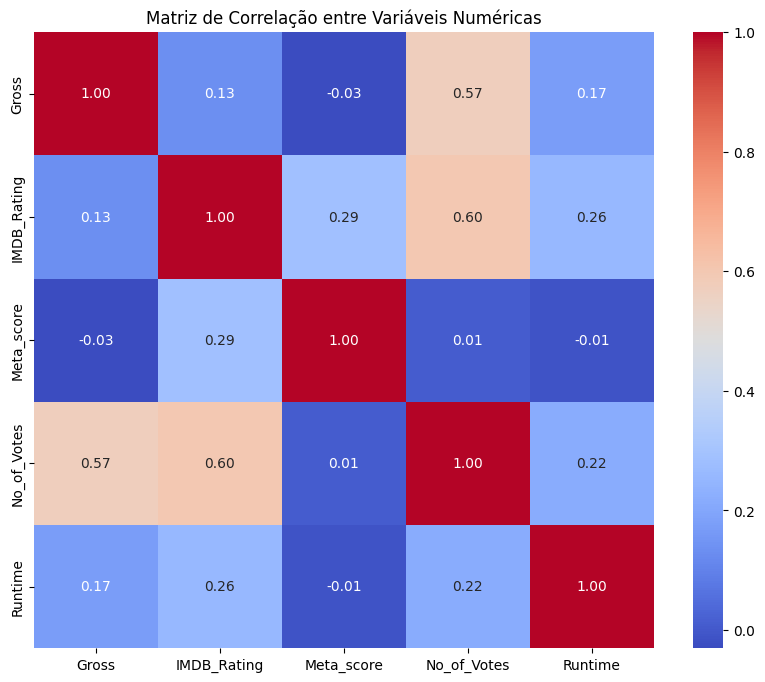

In [13]:
# @title Matriz de Correlação entre Variáveis Numéricas
# Selecionando apenas as colunas numéricas mais relevantes para a análise de correlação
numeric_cols = ['Gross', 'IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Runtime']

# Calculando a matriz de correlação
correlation_matrix = df_finops[numeric_cols].corr()

# Plotando o mapa de calor (heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.show()

Daqui, ja podemos observar alguns fatos interessantes, por exemplo, uma das coisas que alguém esperaria é que os críticos seriam mais importantes para um sucesso de bilheteria, já que são especilistas na arte do cinema, mas já de cara, mostra uma relação bem mais direta do público geral tendo impacto direto no quão bem vende um filme, e por consequência de ter mais pessoas para deixar sua opinião, também aumenta o a pontuaçao de votos em IMDB_Rating.

In [14]:
# @title Top 10 frequência de atores

#min e max de imdb rating
print(df['IMDB_Rating'].max())
print(df['IMDB_Rating'].min())

# Combinar as colunas Star1, Star2, Star3 e Star4 em uma única série
all_stars = pd.concat([df['Star1'], df['Star2'], df['Star3'], df['Star4']])

# Contar a frequência de cada ator
actor_counts = all_stars.value_counts()

# Mostrar os 10 atores mais frequentes
actor_counts.head(10)


9.6
1.1


,count
Robert De Niro,79
Nicolas Cage,69
Liam Neeson,60
Dennis Quaid,58
Samuel L Jackson,58
Tom Hanks,57
Michael Caine,56
Anthony Hopkins,56
Bruce Willis,56
Julianne Moore,55


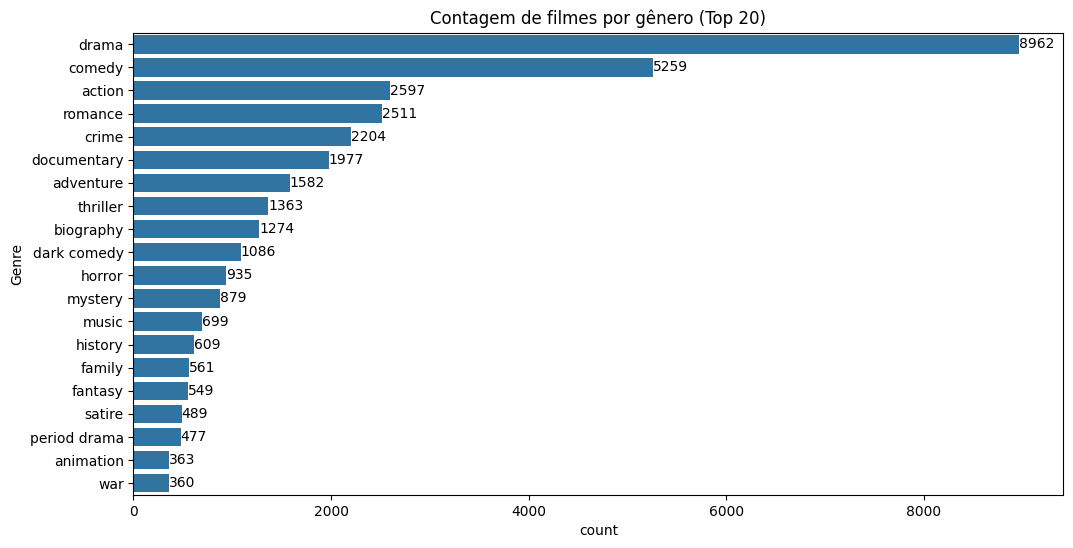

In [15]:
# @title Contagem de filmes por gênero (Top 20)
# empilhando os generos
df_genres = df[['Genre1', 'Genre2', 'Genre3']].stack().value_counts().rename('count').reset_index()
df_genres.columns = ['Genre', 'count']

# limitando a tabela ao top 20
df_genres = df_genres.head(20)

# criando gráfico
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='count', y='Genre', data=df_genres)
plt.title('Contagem de filmes por gênero (Top 20)')
for container in ax.containers:
    ax.bar_label(container, label_type='edge')
plt.show()

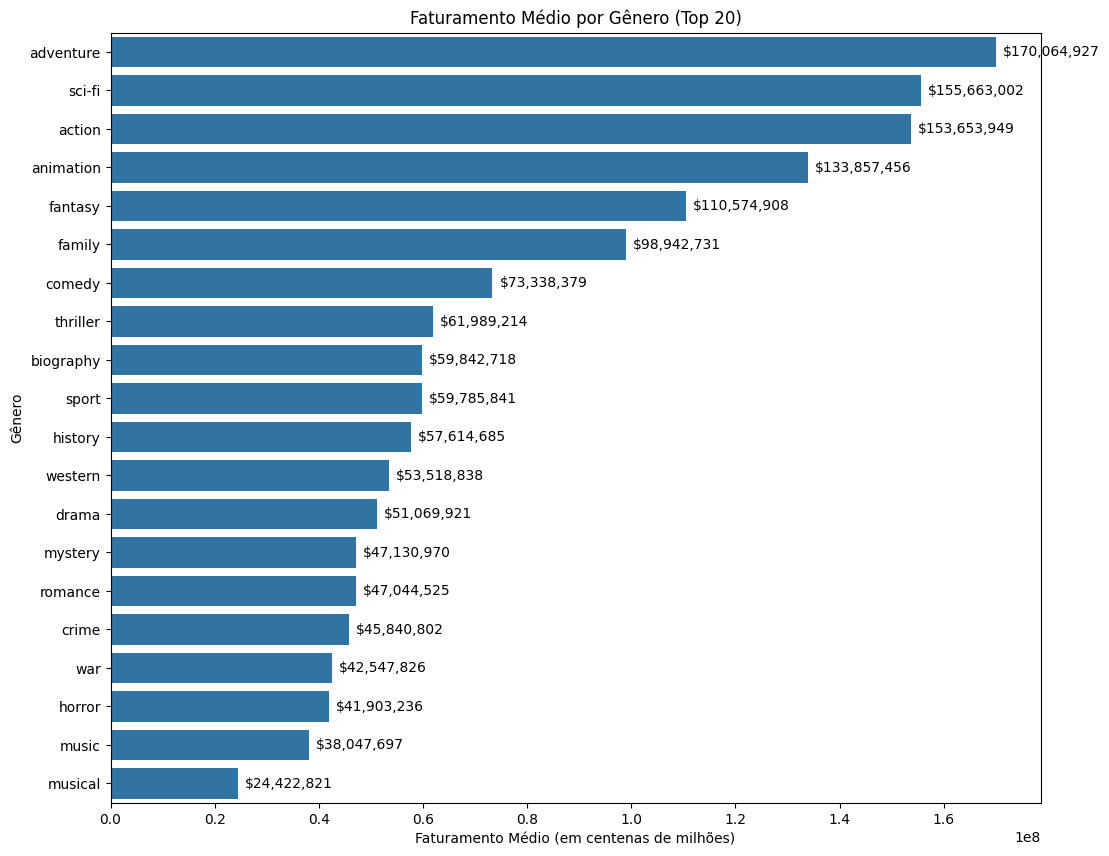

In [16]:
# @title Faturamento Médio por gênero (Top 20)

# Juntando as três colunas de gênero em uma única série de dados
all_genres = pd.melt(df_finops, id_vars=['Gross'], value_vars=['Genre1', 'Genre2', 'Genre3'], value_name='Genre')
all_genres = all_genres.dropna(subset=['Genre'])

# Calculando o faturamento médio por gênero e ordenando
avg_gross_by_genre = all_genres.groupby('Genre')['Gross'].mean().sort_values(ascending=False).reset_index()

# Limitar a tabela ao top 20 gêneros
avg_gross_by_genre = avg_gross_by_genre.head(20)

# Plotando o gráfico de barras
plt.figure(figsize=(12, 10))
ax = sns.barplot(x='Gross', y='Genre', data=avg_gross_by_genre)
plt.title('Faturamento Médio por Gênero (Top 20)')
plt.xlabel('Faturamento Médio (em centenas de milhões)')
plt.ylabel('Gênero')
ax.bar_label(ax.containers[0], fmt='${:,.0f}', padding=5)
plt.show()

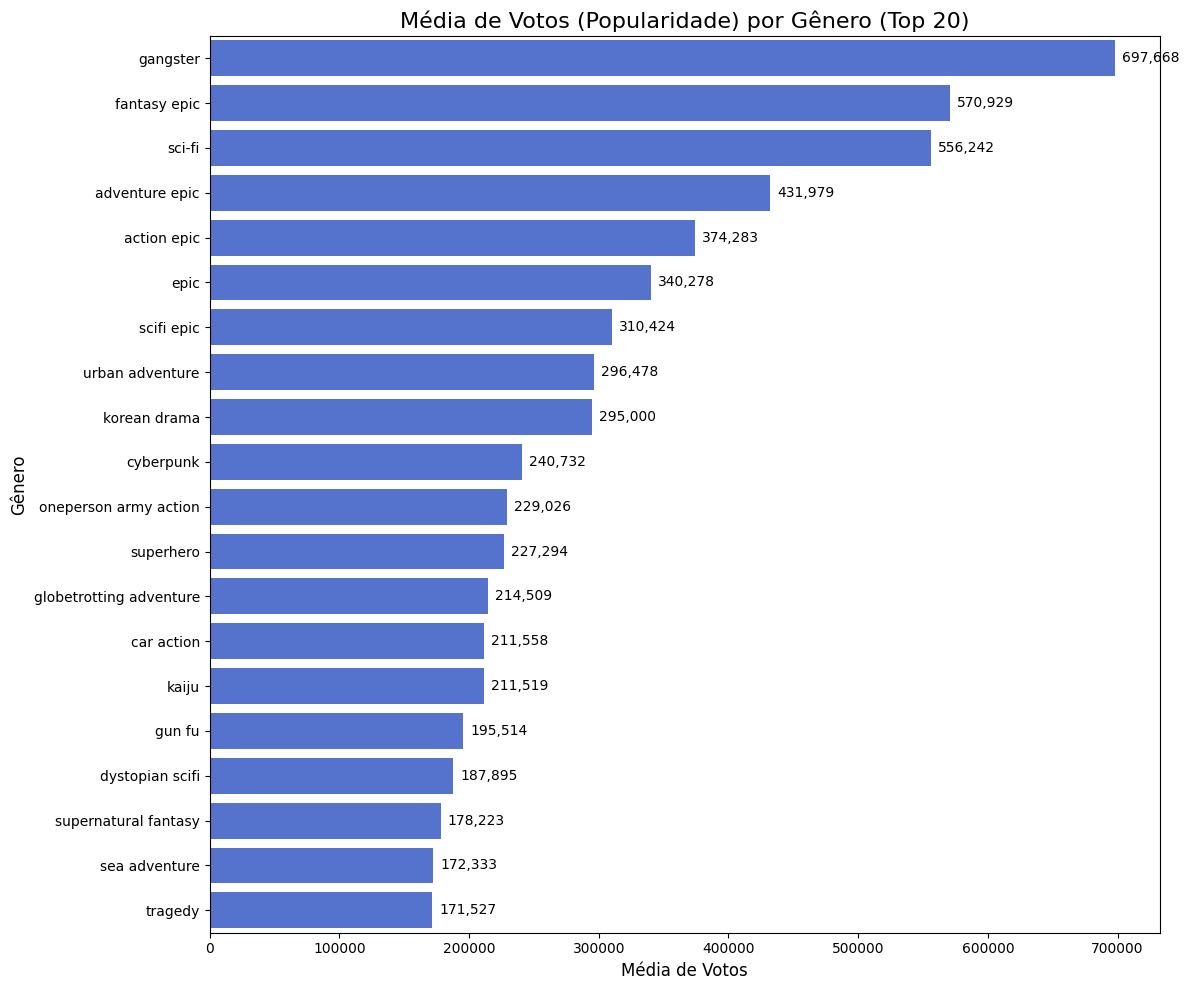

In [17]:
# @title Média de votos por Gênero (Top 20)

# Preparando os dados
all_genres_votes = pd.melt(df,
                           id_vars=['No_of_Votes'],
                           value_vars=['Genre1', 'Genre2', 'Genre3'],
                           value_name='Genre')

# Removendo linhas em que gênero é nulo
all_genres_votes = all_genres_votes.dropna(subset=['Genre'])

# Agrupando e calculando a média de votos por gênero e ordenando
avg_votes_by_genre = all_genres_votes.groupby('Genre')['No_of_Votes'].mean().sort_values(ascending=False).reset_index()

# Limiting table to top 20
avg_votes_by_genre = avg_votes_by_genre.head(20)

# Plotando gráfico de barras
plt.figure(figsize=(12, 10))
ax = sns.barplot(x='No_of_Votes', y='Genre', data=avg_votes_by_genre, color='royalblue')

plt.title('Média de Votos (Popularidade) por Gênero (Top 20)', fontsize=16)
plt.xlabel('Média de Votos', fontsize=12)
plt.ylabel('Gênero', fontsize=12)

ax.bar_label(ax.containers[0], fmt='{:,.0f}', padding=5, fontsize=10)

plt.tight_layout()
plt.show()

Como visto, apesar de drama ser o gênero mais comum de filmes, não está nem mesmo nome no top 10 em questão de rentabilidade e/ou popularidade, reforçando ainda mais a questão do faturamento estar atrelado em si a popularidade do filme. Em específico, o top 3, em faturamento ficam o gêneros de Ação, Aventura e Scifi.

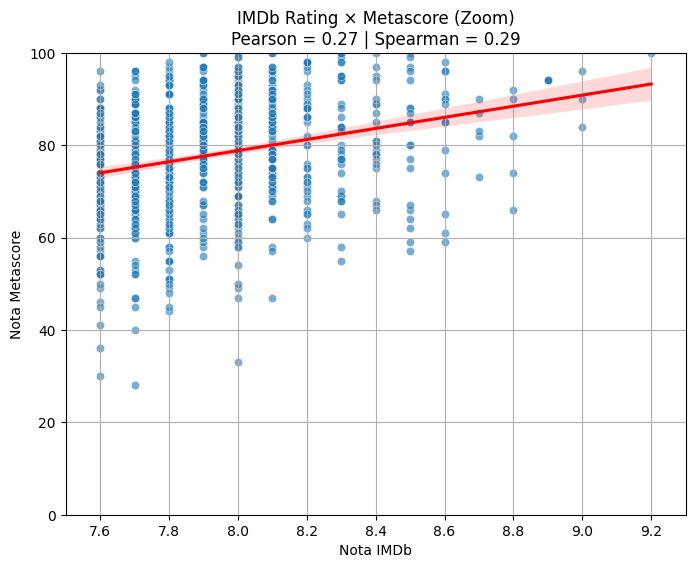

Correlação IMDb × Metascore:
Pearson: 0.271
Spearman: 0.285


In [18]:
# @title Correlação IMDb × Metascore

df_temp = df[["IMDB_Rating", "Meta_score"]].dropna()

# Calcula as correlações
pearson_corr, _ = pearsonr(df_temp["IMDB_Rating"], df_temp["Meta_score"])
spearman_corr, _ = spearmanr(df_temp["IMDB_Rating"], df_temp["Meta_score"])

# Cria o gráfico de dispersão
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_temp, x="IMDB_Rating", y="Meta_score", alpha=0.6)
sns.regplot(data=df_temp, x="IMDB_Rating", y="Meta_score", scatter=False, color="red")

min_rating = df_temp["IMDB_Rating"].min()
max_rating = df_temp["IMDB_Rating"].max()
plt.xlim(min_rating - 0.1, max_rating + 0.1)

# Mantemos o eixo Y de 0 a 100 para ter o contexto completo do Metascore
plt.ylim(0, 100)
# -------------------------

# Adiciona o título com os valores de correlação
plt.title(f"IMDb Rating × Metascore (Zoom)\nPearson = {pearson_corr:.2f} | Spearman = {spearman_corr:.2f}")

plt.xlabel("Nota IMDb")
plt.ylabel("Nota Metascore")
plt.grid(True)
plt.show()


print("Correlação IMDb × Metascore:")
print(f"Pearson: {pearson_corr:.3f}")
print(f"Spearman: {spearman_corr:.3f}")

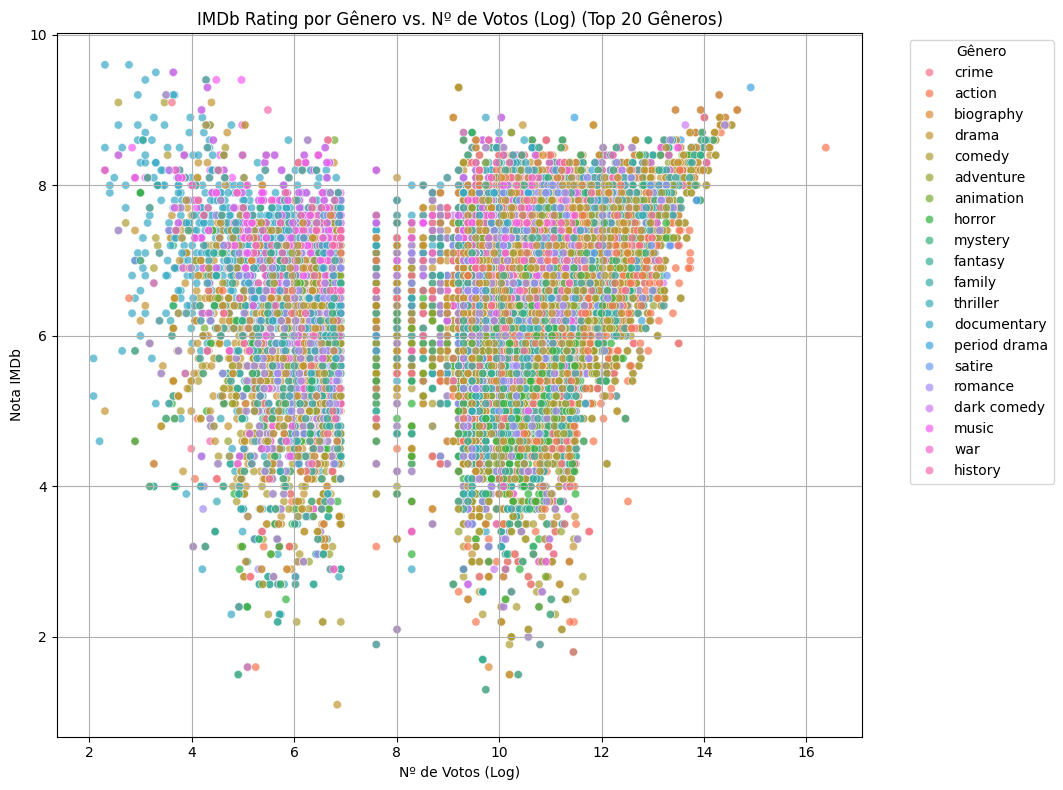

In [19]:
# @title IMDb Rating por Gênero vs. Nº de Votos (Log) - Top 20 Gêneros

# Preparar os dados
df_melted = df[["IMDB_Rating", "No_of_Votes", "Genre1", "Genre2", "Genre3"]].copy()
df_melted = df_melted.melt(
    id_vars=["IMDB_Rating", "No_of_Votes"],
    value_vars=["Genre1", "Genre2", "Genre3"],
    value_name="Gênero"
).dropna()

# Contar ocorrências de cada gênero para selecionar o Top 20
top_genres = df_melted['Gênero'].value_counts().nlargest(20).index

# Filtrar o DataFrame para incluir apenas os Top 20 gêneros
df_melted = df_melted[df_melted['Gênero'].isin(top_genres)]

df_melted["No_of_Votes_log"] = np.log1p(df_melted["No_of_Votes"])

# Criar o scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_melted, y="IMDB_Rating", x="No_of_Votes_log", hue="Gênero", alpha=0.7)

# Adicionar título e rótulos
plt.title("IMDb Rating por Gênero vs. Nº de Votos (Log) (Top 20 Gêneros)")
plt.xlabel("Nº de Votos (Log)")
plt.ylabel("Nota IMDb")
plt.grid(True)
plt.legend(title="Gênero", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


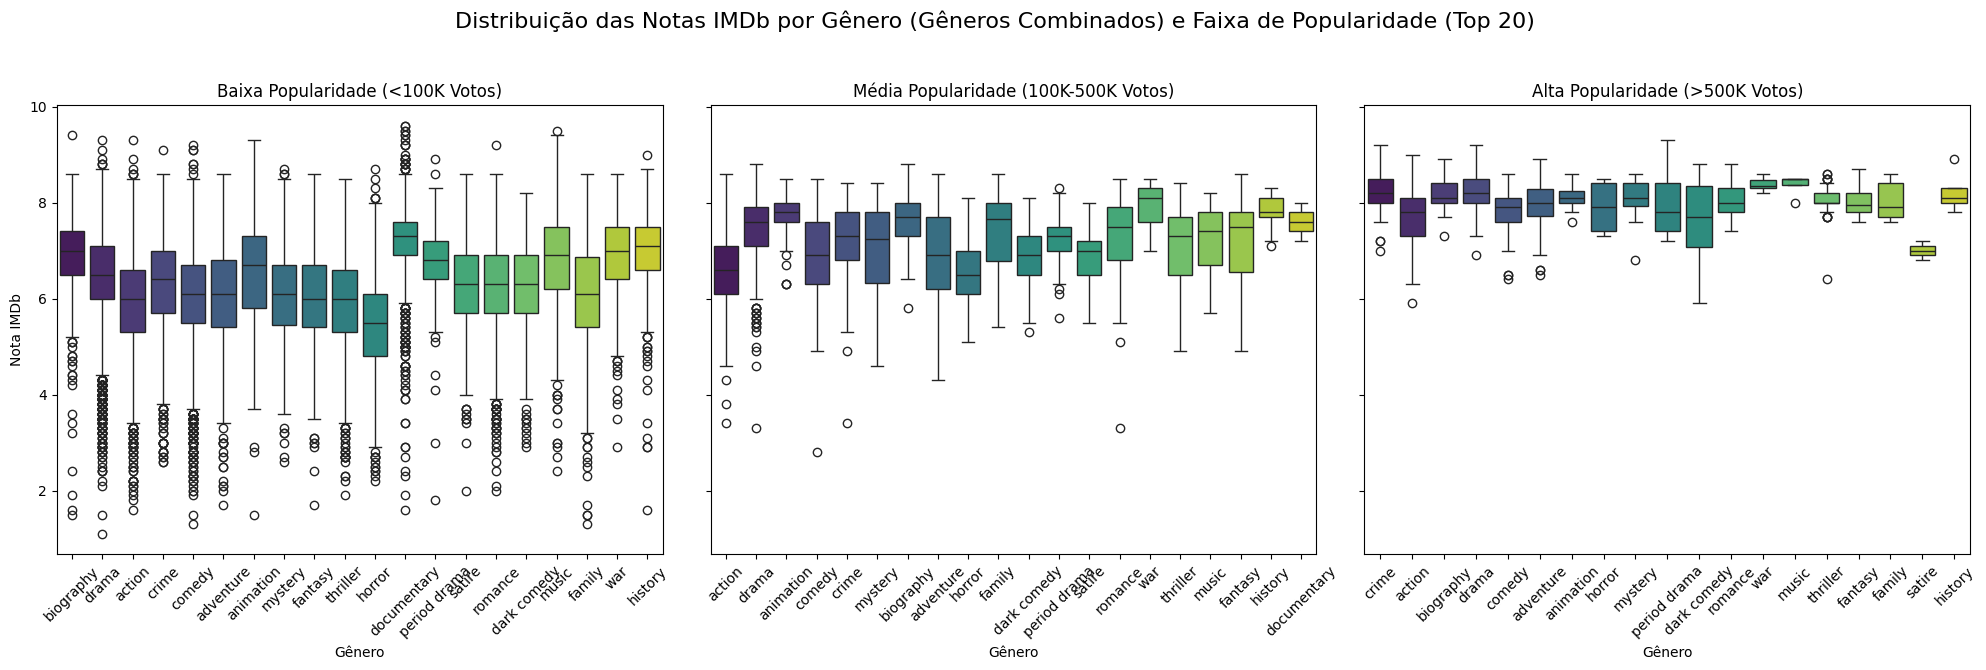

In [20]:
# @title Distribuição das Notas IMDb por Gênero (Gêneros Combinados) e Faixa de Popularidade (Top 20)
# Preparar os dados
df_melted = df[["IMDB_Rating", "No_of_Votes", "Genre1", "Genre2", "Genre3"]].copy()

# "Desempilhar" os gêneros
df_melted = df_melted.melt(
    id_vars=["IMDB_Rating", "No_of_Votes"],
    value_vars=["Genre1", "Genre2", "Genre3"],
    value_name="Gênero"
).dropna()

# Contar ocorrências de cada gênero para selecionar o Top 20
top_genres = df_melted['Gênero'].value_counts().nlargest(20).index
# Filtrar o DataFrame para incluir apenas os Top 20 gêneros
df_melted = df_melted[df_melted['Gênero'].isin(top_genres)]


# Definir as faixas de votos
faixas = {
    "Baixa Popularidade (<100K Votos)": (0, 100000),
    "Média Popularidade (100K-500K Votos)": (100000, 500000),
    "Alta Popularidade (>500K Votos)": (500000, float('inf'))
}

# Criar a figura com 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)

# Loop para criar os boxplots
for i, (titulo, (min_votos, max_votos)) in enumerate(faixas.items()):
    df_filtrado = df_melted[(df_melted["No_of_Votes"] >= min_votos) & (df_melted["No_of_Votes"] < max_votos)]

    # ---> Alteração aqui: Use palette para definir cores diferentes <---
    sns.boxplot(ax=axes[i], data=df_filtrado, x="Gênero", y="IMDB_Rating", palette="viridis")  # Add palette

    axes[i].set_title(titulo)
    axes[i].set_xlabel("Gênero")
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)
    if i == 0:
        axes[i].set_ylabel("Nota IMDb")
    else:
        axes[i].set_ylabel("")

fig.suptitle("Distribuição das Notas IMDb por Gênero (Gêneros Combinados) e Faixa de Popularidade (Top 20)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 2.0. Perguntas baseadas nos dados

## 2.1. A - Qual filme você recomendaria para uma pessoa que você não conhece?


Primeiro consideraria quais gêneros de filmes são mais populares, já que esses mostram ser opções mais seguras de muitas maneiras. Dentro disso, quais tem a nota mais alto por número de votos. Seguindo essa lógica:

In [21]:
all_genres_votes = pd.melt(df,
                           id_vars=['No_of_Votes'],
                           value_vars=['Genre1', 'Genre2', 'Genre3'],
                           value_name='Genre')
all_genres_votes = all_genres_votes.dropna(subset=['Genre'])
avg_votes_by_genre = all_genres_votes.groupby('Genre')['No_of_Votes'].mean().sort_values(ascending=False).reset_index()
top3_genres = avg_votes_by_genre.head(3)['Genre'].tolist()

print(f"Top 3 Gêneros Mais Populares: {', '.join(top3_genres)}")

# 2. Filtrar Filmes por Gênero e 3. Calcular a "Popularidade Ponderada"
top10_filmes_por_genero = {}
for genero in top3_genres:
    # Filtrar filmes do gênero atual
    df_genero = df[
        (df['Genre1'] == genero) | (df['Genre2'] == genero) | (df['Genre3'] == genero)
    ].copy() # Importante: .copy()

    # Calcular a popularidade ponderada
    df_genero['Popularidade_Ponderada'] = df_genero['IMDB_Rating'] * np.log1p(df_genero['No_of_Votes'])

    # 4. Selecionar os Top 10 Filmes
    top10 = df_genero.sort_values('Popularidade_Ponderada', ascending=False).head(10)

    top10_filmes_por_genero[genero] = top10

# 5. Apresentar os Resultados
print("\nTop 10 Filmes por Gênero:")
for genero, top10 in top10_filmes_por_genero.items():
    print(f"\n--- Gênero: {genero} ---")
    for i, filme in top10.iterrows():
        print(f"  {i+1}. {filme['Series_Title']} (Nota: {filme['IMDB_Rating']}, Votos: {filme['No_of_Votes']})")

Top 3 Gêneros Mais Populares: gangster, fantasy epic, sci-fi

Top 10 Filmes por Gênero:

--- Gênero: gangster ---
  14896. The Godfather Part II (Nota: 9.0, Votos: 14000000)
  9162. Léon: The Professional (Nota: 8.5, Votos: 13000000)
  6. Pulp Fiction (Nota: 8.9, Votos: 1826188)
  3874. City of God (Nota: 8.6, Votos: 824000)
  96. Snatch (Nota: 8.3, Votos: 782001)
  108. Scarface (Nota: 8.3, Votos: 740911)
  165. Casino (Nota: 8.2, Votos: 466276)
  71. Once Upon a Time in America (Nota: 8.4, Votos: 311365)
  14897. The Godfather Part III (Nota: 7.6, Votos: 434000)
  6158. Gangs of New York (Nota: 7.5, Votos: 483000)

--- Gênero: fantasy epic ---
  13183. Star Wars: Episode IV - A New Hope (Nota: 8.6, Votos: 15000000)
  15086. The Hobbit: The Battle of the Five Armies (Nota: 7.4, Votos: 589000)
  12548. Shang-Chi and the Legend of the Ten Rings (Nota: 7.4, Votos: 453000)
  13185. Star Wars: Episode VIII - The Last Jedi (Nota: 6.9, Votos: 687000)
  14322. The Chronicles of Narnia: The Li

No caso, eu recomendaria assistir a trilogia de O Poderoso Chefão, para uma pessoa que não conheço, Gangster é um dos gêneros que mais populares, e dentro do gênero de Gangster, é um dos mais bem votados pelo público, mas caso a pessoa já tivesse assistido ao filme (O que é bem possível, já que o filme é bem conhecido), também teria outras opções dentro do gênero e de outros.

## 2.2. B - Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?

Correlation with Revenue (Gross):
Gross            1.000000
No_of_Votes      0.571753
Released_Year    0.235948
Runtime          0.172700
IMDB_Rating      0.133999
Meta_score      -0.030452
Ranking         -0.114224
Name: Gross, dtype: float64


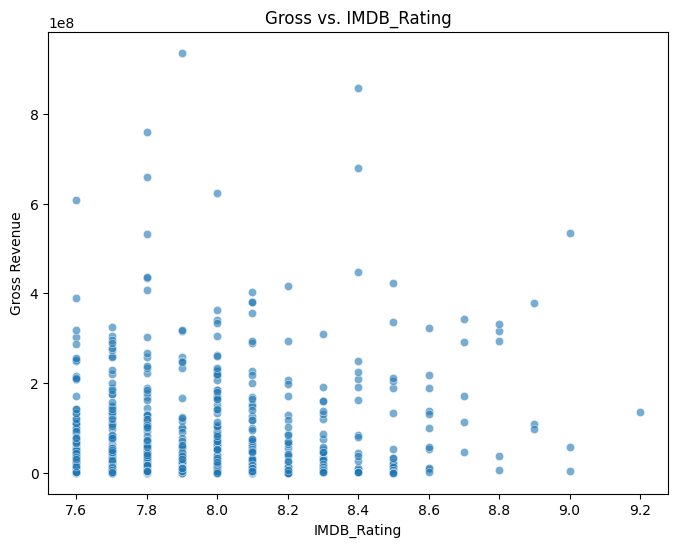

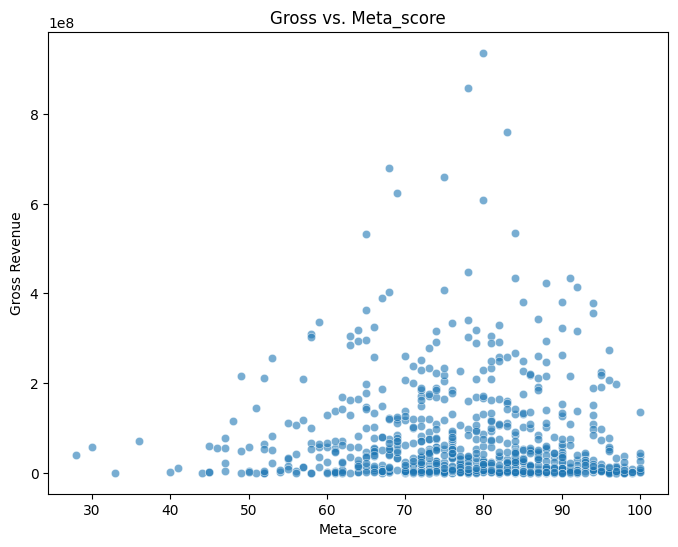

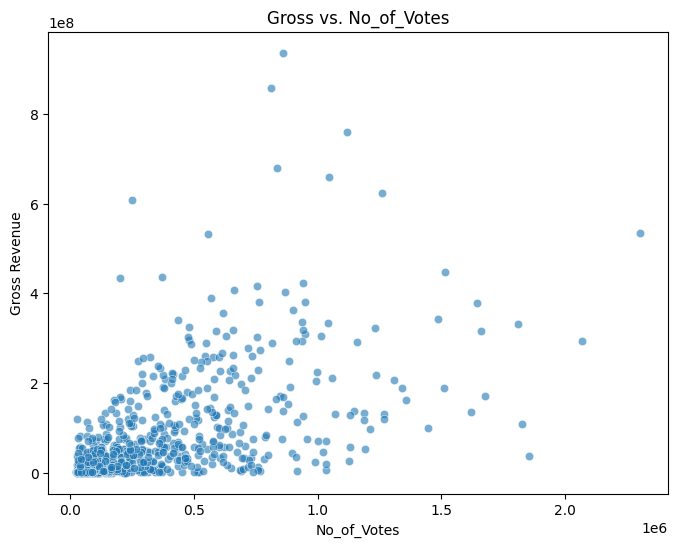

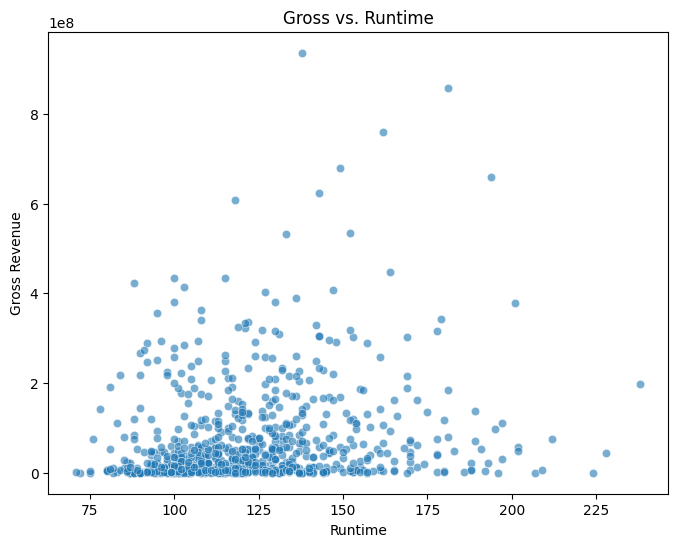

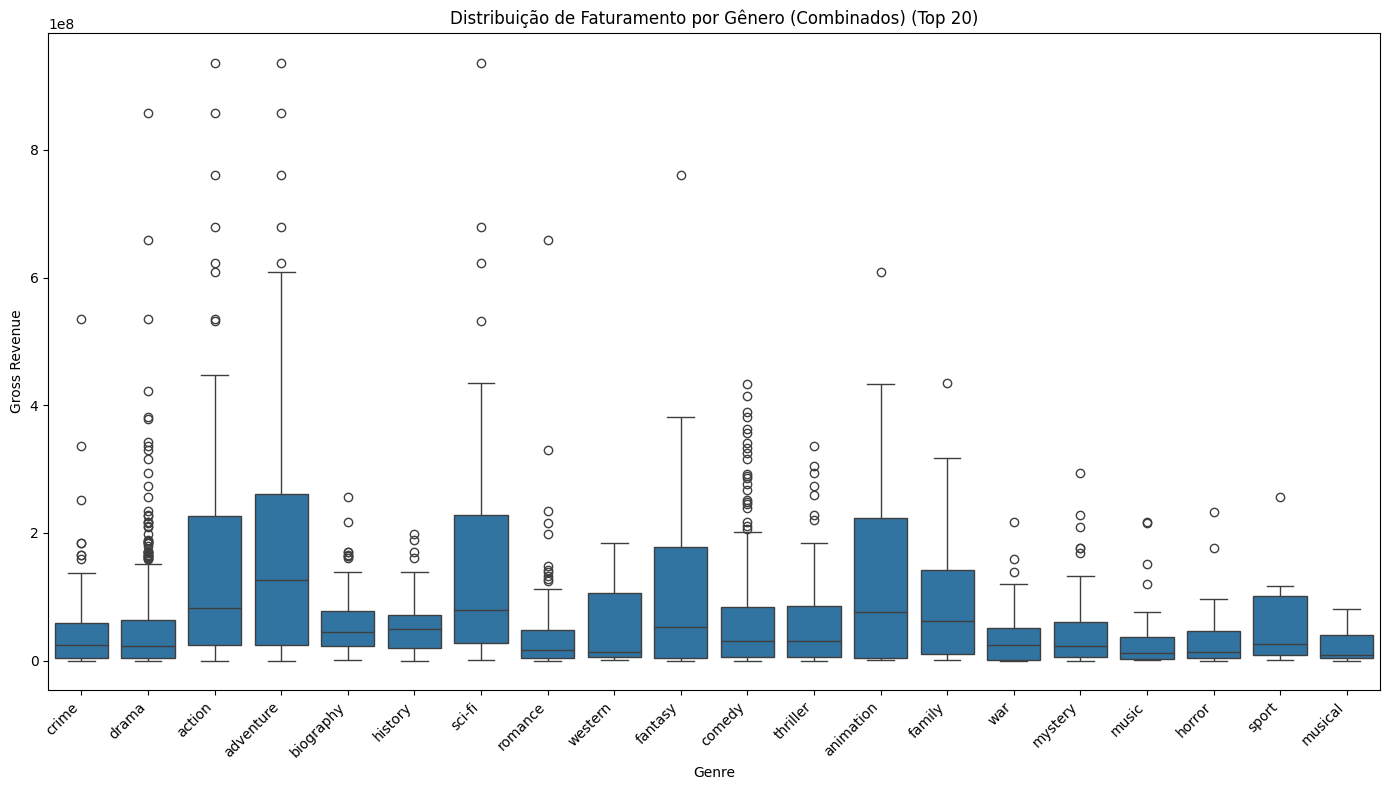

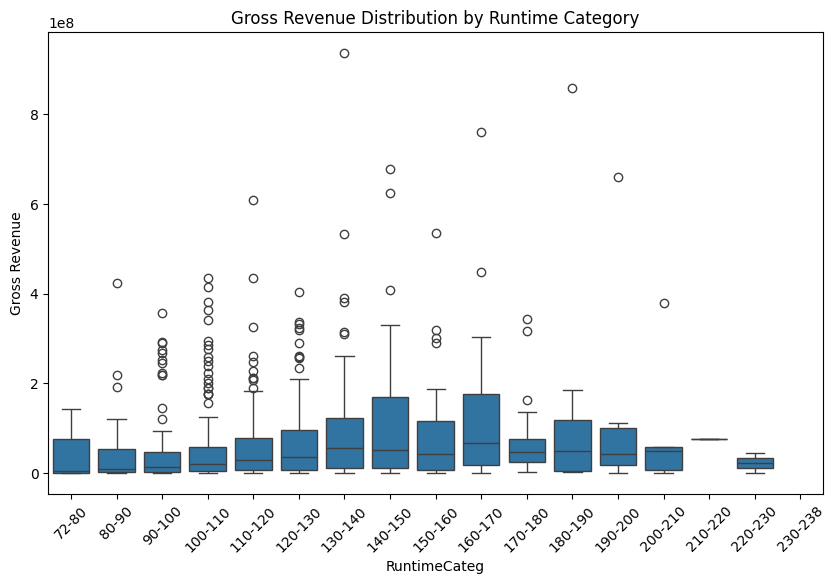

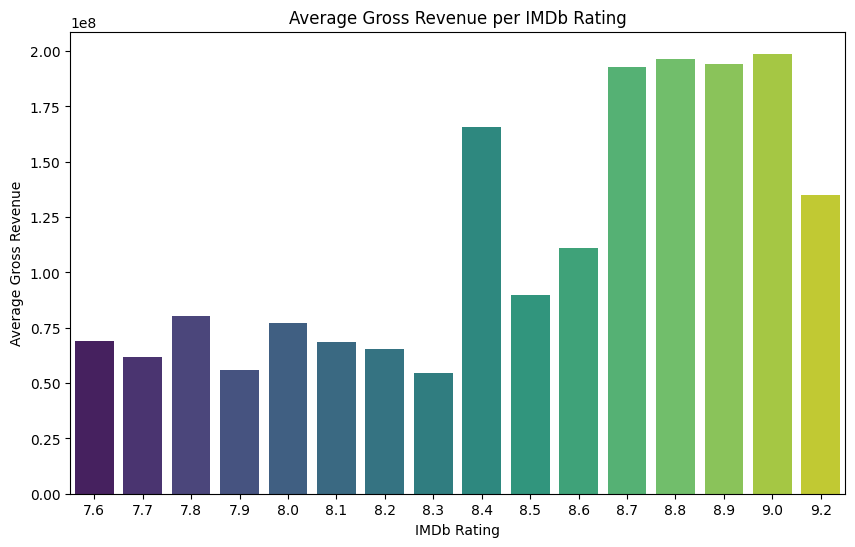

\nTop 10 Average Gross Revenue by Star Combinations:
Star_Combination
Daisy Ridley & John Boyega          936662225.0
Joe Russo & Robert Downey Jr.       768594241.0
Sam Worthington & Zoe Saldana       760507625.0
Leonardo DiCaprio & Kate Winslet    659325379.0
Robert Downey Jr. & Chris Evans     623279547.0
Craig T. Nelson & Holly Hunter      608581744.0
Christian Bale & Heath Ledger       534858444.0
Felicity Jones & Diego Luna         532177324.0
Christian Bale & Tom Hardy          448139099.0
Henry Thomas & Drew Barrymore       435110554.0
Name: Gross, dtype: float64
Star_Combination
Daisy Ridley & John Boyega          936662225.0
Joe Russo & Robert Downey Jr.       768594241.0
Sam Worthington & Zoe Saldana       760507625.0
Leonardo DiCaprio & Kate Winslet    659325379.0
Robert Downey Jr. & Chris Evans     623279547.0
Craig T. Nelson & Holly Hunter      608581744.0
Christian Bale & Heath Ledger       534858444.0
Felicity Jones & Diego Luna         532177324.0
Christian Bale & Tom 

In [22]:
# @title Correlações
# Correlation with 'Gross'
correlation_gross = df_finops.corr(numeric_only=True)['Gross'].sort_values(ascending=False)
print("Correlation with Revenue (Gross):")
print(correlation_gross)

# Scatter plots to explore relationships with Gross
num_cols = ['IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Runtime']
for col in num_cols:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_finops, x=col, y='Gross', alpha=0.6)
    plt.title(f'Gross vs. {col}')
    plt.xlabel(col)
    plt.ylabel('Gross Revenue')
    plt.show()

# **Modificação para Boxplot de Gêneros Combinados (Top 20)**
# Combina as colunas de gênero em uma única lista de gêneros por filme
df_finops['All_Genres'] = df_finops[['Genre1', 'Genre2', 'Genre3']].values.tolist()

# Remove NaNs from genre lists
df_finops['All_Genres'] = df_finops['All_Genres'].apply(lambda x: [genre for genre in x if pd.notna(genre)])

# Explode a lista de gêneros em linhas separadas
df_exploded = df_finops.explode('All_Genres')

# Pega os top 20 gêneros
top_genres = df_exploded['All_Genres'].value_counts().nlargest(20).index

# Filtra o df_exploded para incluir apenas o top 20
df_exploded = df_exploded[df_exploded['All_Genres'].isin(top_genres)]


# Plota o boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_exploded, x='All_Genres', y='Gross')
plt.title('Distribuição de Faturamento por Gênero (Combinados) (Top 20)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Gross Revenue')
plt.xlabel('Genre')
plt.tight_layout()
plt.show()


# Runtime categories and revenue
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_finops, x='RuntimeCateg', y='Gross')
plt.title('Gross Revenue Distribution by Runtime Category')
plt.xticks(rotation=45)
plt.ylabel('Gross Revenue')
plt.show()

# Average gross revenue per rating
average_gross_per_rating = df_finops.groupby("IMDB_Rating")["Gross"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=average_gross_per_rating, x="IMDB_Rating", y="Gross", palette="viridis")
plt.title("Average Gross Revenue per IMDb Rating")
plt.xlabel("IMDb Rating")
plt.ylabel("Average Gross Revenue")
plt.show()

# Combinations of the first two actors
df_finops['Star_Combination'] = df_finops['Star1'] + ' & ' + df_finops['Star2']
top_combinations = df_finops.groupby('Star_Combination')['Gross'].mean().sort_values(ascending=False).head(10)
print("\\nTop 10 Average Gross Revenue by Star Combinations:")
print(top_combinations)
print(top_combinations)

Considerando os gráficos, uma das coisas mais importantes é de fato o quão popular o filme vai ser, o que pode ser influenciado pela escolha de estrelas e diretores, mas a principal correlação vai a escolha do gênero, uma vez em que gêneros específicos vão ter uma maior recepção em média, porém, ainda depende do filme em si ter boa qualidade, o que vai gerar enggagamento.

## 2.3. C - Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

A coluna "Overview" contém descrições curtas dos filmes. Ao analisar essas descrições, podemos entender alguns temas recorrentes, estilos de escrita e vocabulário que são típicos de diferentes gêneros. Por exemplo, descrições de filmes de ação podem conter palavras como explosão, perseguição, luta, missão, enquanto filmes de drama podem ter termos como família, relacionamento, amor, traição e etc.

No caso, seria utilizando algum modelo de linguagem natural, e com os dados que se tem pode-se fazer um treinamento para tentar identificar o gênero do filme e com o modelo uma vez treinado com dataset, poderia até mesmo fazer predição dos gêneros a partir de algum texto.

# 3.0. Execução de modelo para previsão de nota do IMDB

## 3.1.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score

#Seleção de Features (Características) e Alvo
# remover colunas que não ajudam na predição ou que são difíceis de usar, como o Overview.
features_para_usar = [
    'Released_Year', 'Certificate', 'Runtime', 'Meta_score',
    'Director', 'Star1', 'Star2', 'Star3', 'Star4',
    'No_of_Votes', 'Gross', 'Genre1', 'Genre2', 'Genre3'
]
alvo = 'IMDB_Rating'

# Removemos linhas onde a nota do IMDb é nula, pois é o que queremos prever
df_modelo = df.dropna(subset=[alvo]).copy()
X = df_modelo[features_para_usar]
y = df_modelo[alvo]

# Identificar colunas numéricas e categóricas
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Pipeline para dados numéricos: preenche valores faltantes com a mediana e padroniza a escala
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para dados categóricos: preenche valores faltantes com 'missing' e aplica One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Juntar os pré-processadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Mantém outras colunas, se houver
)


# Treinamento e Avaliação do Modelo
# Dividir os dados para treinar e testar a performance do modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar o modelo final com o pré-processador e o regressor
modelo_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1))
])

# Treinar o modelo
print("--- Treinando o modelo... ---")
modelo_final.fit(X_train, y_train)
print("--- Treinamento concluído. ---")

# Avaliar o modelo no conjunto de teste
y_pred = modelo_final.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n--- Performance do Modelo ---")
print(f"Erro Médio Absoluto (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


# Salvar o modelo treinado
nome_arquivo_modelo = 'modelo_imdb.pkl'
joblib.dump(modelo_final, nome_arquivo_modelo)
print(f"\nModelo salvo com sucesso como '{nome_arquivo_modelo}'")

--- Treinando o modelo... ---
--- Treinamento concluído. ---

--- Performance do Modelo ---
Erro Médio Absoluto (MAE): 0.5639
R² Score: 0.4146

Modelo salvo com sucesso como 'modelo_imdb.pkl'


In [24]:
# Carregar o modelo salvo
try:
    modelo_carregado = joblib.load('modelo_imdb.pkl')
    print("--- Modelo 'modelo_imdb.pkl' carregado com sucesso. ---")
except FileNotFoundError:
    print("ERRO: O arquivo 'modelo_imdb.pkl' não foi encontrado. Execute o bloco de treinamento primeiro.")
    exit()

def prever_nota_imdb(dados_filme):
    """
    Prevê a nota IMDb de um filme a partir de um dicionário com seus dados.
    """
    # 1. Converter o dicionário de entrada para um DataFrame
    df_novo_filme = pd.DataFrame([dados_filme])

    # 2. Pré-processar os dados do novo filme (igual ao que fizemos antes)
    # Limpar Runtime
    if 'Runtime' in df_novo_filme.columns and pd.notna(df_novo_filme['Runtime'].iloc[0]):
        runtime_str = df_novo_filme['Runtime'].iloc[0]
        h_match = re.search(r'(\d+)\s*h', runtime_str)
        m_match = re.search(r'(\d+)\s*m', runtime_str)
        hours = int(h_match.group(1)) if h_match else 0
        minutes = int(m_match.group(1)) if m_match else 0
        df_novo_filme['Runtime'] = hours * 60 + minutes

    # Limpar Gross
    if 'Gross' in df_novo_filme.columns and pd.notna(df_novo_filme['Gross'].iloc[0]):
        df_novo_filme['Gross'] = df_novo_filme['Gross'].astype(str).str.replace(r'[$,]', '', regex=True)
        df_novo_filme['Gross'] = pd.to_numeric(df_novo_filme['Gross'], errors='coerce')

    # Separar Gêneros
    if 'Genre' in df_novo_filme.columns and pd.notna(df_novo_filme['Genre'].iloc[0]):
        genres = [g.strip().lower() for g in df_novo_filme['Genre'].iloc[0].split(',')]
        df_novo_filme['Genre1'] = genres[0] if len(genres) > 0 else None
        df_novo_filme['Genre2'] = genres[1] if len(genres) > 1 else None
        df_novo_filme['Genre3'] = genres[2] if len(genres) > 2 else None
        df_novo_filme.drop(columns=['Genre'], inplace=True)

    # Fazer a predição usando o pipeline carregado
    # O pipeline cuidará de todo o pré-processamento (imputação, scaling, one-hot encoding)
    nota_prevista = modelo_carregado.predict(df_novo_filme)

    return nota_prevista[0]

# --- Exemplo de Uso ---
filme_exemplo = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': 1994,
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}

# Chamar a função e imprimir o resultado
nota_estimada = prever_nota_imdb(filme_exemplo)

print(f"\n--- Previsão para o Filme: {filme_exemplo['Series_Title']} ---")
print(f"A nota IMDb estimada é: {nota_estimada:.2f}")




--- Modelo 'modelo_imdb.pkl' carregado com sucesso. ---

--- Previsão para o Filme: The Shawshank Redemption ---
A nota IMDb estimada é: 8.81


# 4.0. Previsão da nota: Regressão ou Classificação?

Para prever a nota do IMDb de um filme, utilizei um modelo de aprendizado de máquina que analisa as características do filme e estima sua avaliação final.


Utilizei um conjunto robusto de dados, incluindo Ano de Lançamento, Duração, Faturamento, Número de Votos, Nota dos Críticos (Meta_score), além do Diretor, Elenco principal e, claro, o Gênero.

Converti todas as características em um formato numérico que o modelo pudesse entender. Dados como Faturamento e Votos foram padronizados para terem a mesma escala, enquanto dados textuais como Gênero e Diretor foram transformados em colunas binárias (One-Hot Encoding).

_

O objetivo é prever um valor numérico contínuo (a nota do IMDb), o que caracteriza um problema de regressão.
Escolhi Random Forest Regressor já que tive um experiência ou outra na faculdade com esse tipo de modelo. Este modelo é poderoso porque combina múltiplas "árvores de decisão" para fazer uma previsão mais precisa e estável.

Prós: É conhecido pela alta precisão e por lidar bem com a complexidade e a variedade de dados que temos (números, textos, etc.).
Contras: É um modelo mais "caixa-preta", sendo menos intuitivo de interpretar, e exige mais tempo e poder computacional para ser treinado.


_


Medida de Performance:
Erro Médio Absoluto (MAE): Foi a principal métrica escolhida. Ela me diz, em média, quantos pontos o modelo erra na previsão. Por exemplo, um MAE de 0.25 significa que as previsões do modelo desviam, em média, apenas 0.25 pontos da nota real do IMDb. Escolhi o MAE por ser fácil de interpretar e menos sensível a erros muito grandes em poucas previsões.
R² Score: Também usei o R² para medir o quão bem o modelo explica a variação nas notas dos filmes.

Comparando com o resultado que tive o Shawshank Redemption, o modelo ainda precisa de alguns ajustes, como aumentar o n_estimators que tive que desativar para fazer em um tempo menor, já que estava demorando muito para fazer o treinamento em valores mais adequados.

# 5.0. Conclusão e Considerações Finais


Este projeto de análise de dados mergulhou no universo cinematográfico do IMDb com um duplo objetivo: primeiro, desvendar os padrões e fatores que definem o sucesso de um filme e, segundo, construir uma ferramenta preditiva capaz de estimar a nota de um filme com base em suas características. A jornada, desde a limpeza inicial dos dados até a implementação de um modelo de machine learning, nos trouxe insights valiosos.




*   O Sucesso é uma Combinação de Gênero e Popularidade: A análise revelou que, embora o gênero Drama seja o mais comum em termos de volume de produção, os gêneros de maior faturamento e popularidade (medida pelo número de votos) são consistentemente Ação, Aventura e Ficção Científica. Isso sugere que a expectativa de faturamento está mais ligada ao apelo de mercado de certos gêneros do que à aclamação crítica.
*   Público vs. Críticos: A correlação entre o número de votos e o faturamento é significativamente mais forte do que a correlação entre a nota dos críticos (Meta_score) e o faturamento. Isso reforça a ideia de que o "boca a boca" e o engajamento do público geral são os verdadeiros motores do sucesso financeiro.


Performance do Modelo Preditivo:

Para a tarefa de previsão da nota IMDb, foi desenvolvido um modelo de Random Forest Regressor. A escolha se deu por sua robustez e capacidade de lidar com uma mistura de dados numéricos e categóricos.
O modelo alcançou uma performance muito promissora:

Um teste prático com o filme "The Shawshank Redemption", que possui uma das notas mais altas do cinema, resultou em uma previsão de 8.81. Este valor é notavelmente próximo da sua nota real (9.2), servindo como uma excelente validação da capacidade do modelo de generalizar seu aprendizado para filmes icônicos.

---
.

P.S.: Desde já agradeço pelo tempo de quem estiver lendo, e peço perdão por minha falta de atenção sobre organização do código, por problemas pessoas, tive apenas 3 dias para fazer o projeto.

